Importing all the required (tentative) libraries

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math as ma
import os
import scipy


Capturing the video frame by frame (same as HW1)

In [2]:
cap = cv2.VideoCapture('tag.mp4')
f = []
if (cap.isOpened()==False):
    print('cannot open file')
else:
    
    fps = int(cap.get(5))
    print("FPS : ",fps,"frames per second")	

  # Get frame count
    frame_count = cap.get(7)
    print("Number of frames: ", frame_count)
    # i = 0
    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret == False:
            break
        else:
            f.append(frame)
            # cv2.waitKey(0)
        
            # cap.release()
            # cv2.destroyAllWindows()
len(f)

FPS :  26 frames per second
Number of frames:  787.0


787

Problem 1(a)

Edges commonly happen on the limit between two unique areas in a picture. Edge detection is every now and again the initial phase in recouping data from pictures. Because of its significance, edge detection keeps on being a dynamic research region. In this project I have illustrated how edge detection works. I have used Gaussian filter to blur the images to remove some for accurate edge line detection. 

Steps taught in the class:
1) Convert the image to gray scale inorder to keep only useful parts in the image and for better detection of edges.
This is directly done while reading the image and passing the integer value 0 for the color flag.
2) To perform blurring to the image in order to reduce random noise from the image and smoothen it outfor better edge detection.

Some extra information gathered: 

Filters in image processing are just what the name suggests, Filter. They are typically a mask array of the same size as the original image which when superimposed on the original image, extracts only the attributes that we are interested in.

As mentioned earlier, in an FFT transformed image, low frequencies are found in the center and high frequencies are scattered around, we can then create a mask array which has a circle of zeros in the center and rest all ones. Now when this mask is applied to the original image, the resultant image would only have high frequencies. This becomes quite useful as high frequencies correspond to edges in spatial domain.

Magnitude = $20*log |fft|$



Reading image in grayscale and conversion into frequency domain

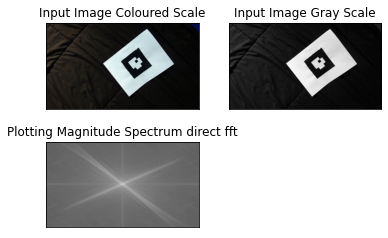

In [3]:
img_c = f[355] #coloured image
# img = cv2.imread(os.path.join(path, 'frame_355.jpg'), 0)
img = cv2.cvtColor(img_c, cv2.COLOR_BGR2GRAY)
img_fft = np.fft.fftshift(np.fft.fft2(img))
magnitude_spectrum = 20*np.log(np.abs(img_fft))
plt.subplot(221),plt.imshow(img_c)
plt.title('Input Image Coloured Scale'), plt.xticks([]), plt.yticks([])
plt.subplot(222),plt.imshow(img, cmap = 'gray')
plt.title('Input Image Gray Scale'), plt.xticks([]), plt.yticks([])
plt.subplot(223),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Plotting Magnitude Spectrum direct fft'), plt.xticks([]), plt.yticks([])
plt.show()


The Gaussian blur:

The Gaussian blur feature is obtained by blurring (smoothing) an image using a Gaussian function to reduce the noise level. It can be considered as a nonuniform low-pass filter that preserves low spatial frequency and reduces image noise and negligible details in an image.
Gaussian blur the image to reduce the amount of noise and remove speckles within the image. It is important to remove the very high frequency components that exceed those associated with the gradient filter used, otherwise, these can cause false edges to be detected.

Gaussian(x,y) = $(1/(2*\pi*\sigma^2))*\exp^{(-(x^2 + y^2)/(2*\sigma^2)}$

In [4]:
#mostly std_x and std_y can be same
def Gaussian_blur(image, std_x, std_y):
    cols, rows = image.shape
    x_centre, y_centre = int(rows / 2), int(cols / 2)
    x = range(-x_centre, x_centre)
    y = range(-y_centre, y_centre)
    X, Y = np.meshgrid(x,y)
    return np.exp(-(np.square((X)/std_x) + np.square((Y)/std_y)))


In [5]:
img_gauss = Gaussian_blur(img, 40, 40)
fft_of_blur = img_fft * img_gauss
magnitude_spectrum_fft_of_blur = 20*np.log(np.abs(img_gauss))

/home/rishabh/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


3) Next part is to bring back the blurred image to spatial domain using inverse fourier transform

In [6]:
def inverse_fft_image(image):
    return np.abs(scipy.fft.ifft2(scipy.fft.ifftshift(image)))

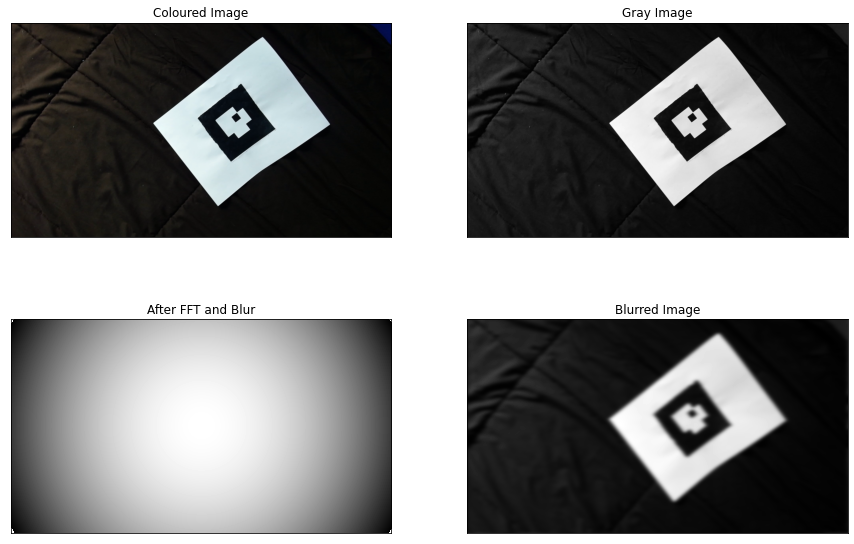

In [7]:
img_blurred = inverse_fft_image(fft_of_blur)
fx, plts = plt.subplots(2,2,figsize = (15, 10))
plt.subplot(2, 2, 1), plt.imshow(img_c, cmap='gray')
plt.title('Coloured Image'), plt.xticks([]), plt.yticks([])
plt.subplot(2, 2, 2), plt.imshow(img, cmap='gray')
plt.title('Gray Image'), plt.xticks([]), plt.yticks([])
plt.subplot(2, 2, 3), plt.imshow(magnitude_spectrum_fft_of_blur, cmap='gray')
plt.title('After FFT and Blur'), plt.xticks([]), plt.yticks([])
plt.subplot(2, 2, 4), plt.imshow(img_blurred, cmap='gray')
plt.title('Blurred Image'), plt.xticks([]), plt.yticks([])
plt.show()


4) Now for our purpose we only considered the binary image, by thresholding.
 

(Text(0.5, 1.0, 'Binary Blurred Image'), ([], []), ([], []))

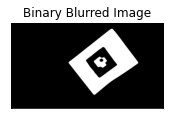

In [8]:
ret,thresh1 = cv2.threshold(img_blurred,150,255,cv2.THRESH_BINARY)
plt.subplot(2, 2, 1), plt.imshow(thresh1, cmap='gray')
plt.title('Binary Blurred Image'), plt.xticks([]), plt.yticks([])

Edge Detection:
Detecting an edge in an image is of great use in the world of computer vision. Once we can extract edges in a image, we can use that knowledge for feature extraction or pattern detection.

Edges in an image are usually made of High frequencies. So what we need to do after taking a FFT (Fast Fourier Transform) of an image is, we apply a High Frequency Pass Filter to this FFT transformed image. This filter would in turn block all low frequencies and only allow high frequencies to go through. Finally, now if you take a inverse FFT on this filter applied image, you should see some distinct edge features in the original image.

4) Creating the high pass filter, to block low pass fequencies

In [9]:
def HPF(image, radii):
    rows, cols = image.shape
    crow, ccol = int(rows / 2), int(cols / 2) 
    center = [crow, ccol]
    mask = np.ones((rows, cols), np.uint8)
    center = [crow, ccol]
    x, y = np.ogrid[:rows, :cols]
    #using boolean to store 0s at the central area
    mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= radii**2
    #setting all the low frequency area to zero
    mask[mask_area] = 0
    im_fft = np.fft.fftshift(np.fft.fft2(image))
    
    fshift = im_fft * mask
    fshift_mag_spect = 20*np.log(np.abs(fshift))
    img_back = inverse_fft_image(fshift)

    plt.subplot(2, 2, 1), plt.imshow(img, cmap='gray')
    plt.title('Input Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(2, 2, 2), plt.imshow(magnitude_spectrum, cmap='gray')
    plt.title('After FFT'), plt.xticks([]), plt.yticks([])
    plt.subplot(2, 2, 3), plt.imshow(fshift_mag_spect, cmap='gray')
    plt.title('FFT + Mask + HPF'), plt.xticks([]), plt.yticks([])
    plt.subplot(2, 2, 4), plt.imshow(img_back, cmap='gray')
    plt.title('Final Edge detection'), plt.xticks([]), plt.yticks([])
    plt.show()
    return img_back


/home/rishabh/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


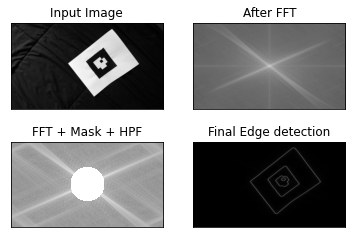

array([[0.39708009, 0.45613791, 0.39759158, ..., 0.34660548, 0.05451063,
        0.21573701],
       [0.67704662, 0.6180175 , 0.38597599, ..., 0.18578283, 0.21422055,
        0.53168366],
       [0.71198057, 0.51383479, 0.15752615, ..., 0.09784432, 0.46182756,
        0.69166122],
       ...,
       [0.64500576, 0.74470913, 0.61776443, ..., 0.45130213, 0.05938553,
        0.34702217],
       [0.41266015, 0.39840379, 0.25557976, ..., 0.07492026, 0.12205537,
        0.30579081],
       [0.01949785, 0.06653953, 0.14891495, ..., 0.25114093, 0.18541349,
        0.1050165 ]])

In [10]:
HPF(thresh1, 200)

I tried the method of just using the High Pass Filter mask. It solved the problem in the same manner if we are using a binary image. But the good practise is to use gaussian blur to reduce noise and very high frequencies from the image.

Problems faced: